In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for multiple tockets
#50 tockets
# Scarica lista S&P500 da Wikipedia
tickers = pd.read_csv("/home/ceci/ProblemSolving/notebooks/constituents.csv")["Symbol"].tolist()

# Alcuni ticker hanno un punto (es. BRK.B, BF.B) → Yahoo li vuole con trattino
tickers = [t.replace(".", "-") for t in tickers]
data = yf.download(tickers, start="2023-01-01", end="2025-01-01")['Close']
data = data.dropna(axis=1, how='all')

/tmp/ipykernel_1637/1040873868.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2023-01-01", end="2025-01-01")['Close']
[*********************100%***********************]  503 of 503 completed

1 Failed download:
['L']: Timeout('Failed to perform, curl: (28) Operation timed out after 10000 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [13]:
nan_frac = data.isna().mean()
# tieni solo colonne con meno del 5% di NaN
ok_cols = nan_frac[nan_frac <= 0.05].index
data_clean = data[ok_cols]
data_clean = data_clean.fillna(method='ffill').fillna(method='bfill')
subset = data_clean.iloc[:, :100]

returns = returns(subset)

R = returns.dropna(how="any").to_numpy(dtype=float)   # shape: (T, N)

T, N = R.shape
print("R shape:", R.shape)
print("First 5 rows of R:\n", R[:5])

R shape: (501, 100)
First 5 rows of R:
 [[ 0.66088237  0.66010616  0.55296757  1.79207239  1.23228757  0.26746413
  -0.27176444  0.57976127  1.12162529 -1.90706173  0.36185829  0.76123025
   0.4142716   0.54203695 -1.25163555  0.30528894  0.9658928   0.856086
   1.07185981  0.58802849  1.2917346   1.88608781  1.05227395  0.93746968
   1.03993391  0.68291475  0.29090573  0.14359917  0.70123113  0.40589642
   1.24127435 -0.51042842 -2.32511039  0.8531439   1.76864854 -1.42637699
   0.00505913  0.92815902  1.1074184   1.39509895  1.01942916  0.56886385
   1.28263541  0.33673236  1.51666155  1.53569639  0.02296973  1.36852122
   0.40434121  2.12163003  1.151074    0.55407001  1.36463614  1.00719696
   0.63628155  1.44591602  0.58368533 -0.33980636 -0.36906967  1.73750788
   2.2205404  -1.82421636  0.68261301  1.02137546  0.34596519  1.21686566
   1.58825673  1.2738742   0.7993948   1.12736492  0.03754188  1.49910585
  -0.3229744   0.19176537  0.48826612  0.54871836  1.33033153 -1.28704366


/tmp/ipykernel_1637/3168879683.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean = data_clean.fillna(method='ffill').fillna(method='bfill')


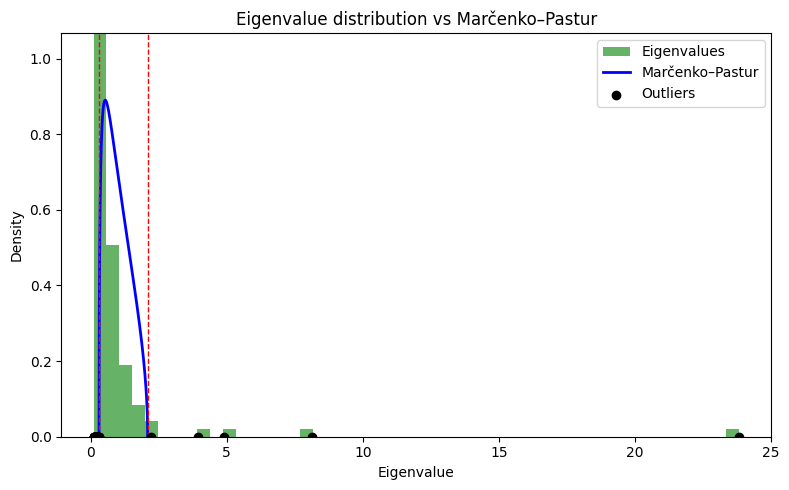

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")
from finrmt.data import returns
from finrmt.rmt import mp_bounds
C = (1/T) * R.T @ R
eigvals = np.linalg.eigvalsh(C)

# bounds MP
lam_minus, lam_plus = mp_bounds(N, T, sigma2=1.0)
bounds = (lam_minus, lam_plus)
# istogramma autovalori
plt.figure(figsize=(8,5))
plt.hist(eigvals, bins=50, density=True, alpha=0.6, color='g', label="Eigenvalues")
q = N / T
# curva MP (analitica)
x = np.linspace(lam_minus, lam_plus, 400)
rho = (1/(2*np.pi*q*x)) * np.sqrt((lam_plus - x)*(x - lam_minus))
plt.plot(x, rho, 'b-', lw=2, label="Marčenko–Pastur")

# bounds verticali
plt.axvline(lam_minus, color='r', linestyle='dashed', lw=1)
plt.axvline(lam_plus, color='r', linestyle='dashed', lw=1)

# evidenzio outlier
outliers = eigvals[(eigvals < lam_minus) | (eigvals > lam_plus)]
plt.scatter(outliers, np.zeros_like(outliers), color='k', marker='o', zorder=5, label="Outliers")

# rescaling verticale (focalizza sul bulk)
plt.ylim(0, max(rho)*1.2)

plt.title("Eigenvalue distribution vs Marčenko–Pastur")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


confronto con matrice gaussiana

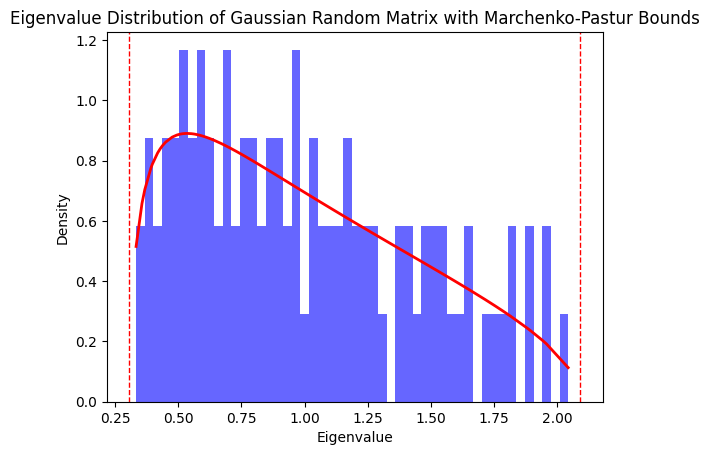

/tmp/ipykernel_1637/1469395808.py:28: RuntimeWarning: invalid value encountered in sqrt
  mp = (1/(2*np.pi*N/T)) * np.sqrt((bounds[0] - x)*(x - bounds[1])) / x


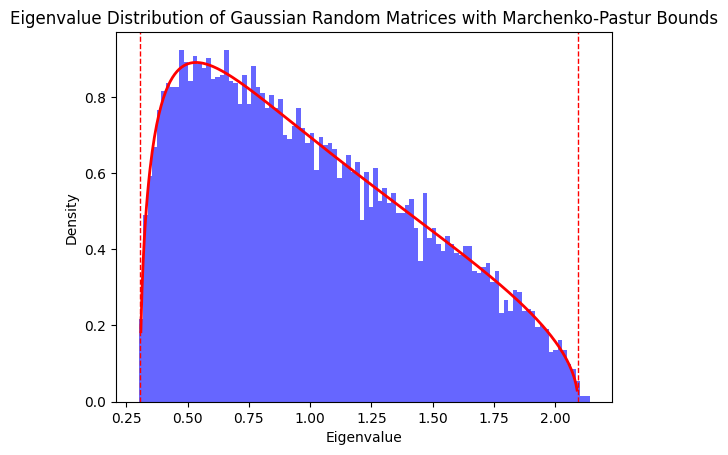

In [23]:

R_gauss = np.random.normal(0, 1, size=(T, N))
C_gauss = (1/T) * R_gauss.T @ R_gauss
eigvals_gauss = np.linalg.eigvalsh(C_gauss)
plt.hist(eigvals_gauss, bins=50, density=True, alpha=0.6, color='b')
plt.axvline(bounds[0], color='r', linestyle='dashed', linewidth=1)
plt.axvline(bounds[1], color='r', linestyle='dashed', linewidth=1)
mp = (1/(2*np.pi*N/T)) * np.sqrt((bounds[1]-eigvals_gauss)*(eigvals_gauss-bounds[0])) / eigvals_gauss
plt.plot(eigvals_gauss, mp, 'r-', lw=2)
plt.title("Eigenvalue Distribution of Gaussian Random Matrix with Marchenko-Pastur Bounds")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()

#generate many gaussians
num_simulations = 100
all_eigvals = []
for _ in range(num_simulations):
    R_gauss = np.random.normal(0, 1, size=(T, N))
    C_gauss = (1/T) * R_gauss.T @ R_gauss
    eigvals_gauss = np.linalg.eigvalsh(C_gauss)
    all_eigvals.extend(eigvals_gauss)
plt.hist(all_eigvals, bins=100, density=True, alpha=0.6, color='b')
plt.axvline(bounds[0], color='r', linestyle='dashed', linewidth=1)
plt.axvline(bounds[1], color='r', linestyle='dashed', linewidth=1)
lambda_minus, lambda_plus = min(all_eigvals), max(all_eigvals)
x = np.linspace(lambda_minus, lambda_plus, 400)

mp = (1/(2*np.pi*N/T)) * np.sqrt((bounds[0] - x)*(x - bounds[1])) / x
plt.plot(x, mp, 'r-', lw=2)
plt.title("Eigenvalue Distribution of Gaussian Random Matrices with Marchenko-Pastur Bounds")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()


prova a togliere la standardizzazione

In [12]:
#r statistics reale

from finrmt.spectra import r_stat

#bootstrap su r statistics, blocks of 5 days, on the real data matrix R



bootstrap_samples = 1000
r_stats_all = []
block_size = 5
num_blocks = T // block_size
for _ in range(bootstrap_samples):
    block_indices = np.random.choice(num_blocks, num_blocks, replace=True)
    sampled_indices = np.concatenate([np.arange(b*block_size, (b+1)*block_size) for b in block_indices])
    R_sampled = R[sampled_indices, :]
    C_sampled = (1/R_sampled.shape[0]) * R_sampled.T @ R_sampled
    eigs_sampled = np.linalg.eigvalsh(C_sampled)
    eigs_sorted = np.sort(eigs_sampled)
    r_stats = r_stat(eigs_sorted, trim_k=0)
    r_stats_all.append(r_stats)
plt.hist(r_stats_all, bins=50, density=True, alpha=0.6, color='m')
plt.vlines(np.mean(r_stats_all), color='k', linestyle='dashed', linewidth=1, label='Mean r-statistics = 0.525', ymin=0, ymax=plt.ylim()[1])
plt.legend()
plt.title("r-Statistics Distribution (Bootstrap over 5-day blocks)")
plt.xlabel("r-Statistic")
plt.ylabel("Density")
plt.show()

print("mean r-statistic:", np.mean(r_stats_all))
print("std r-statistic:", np.std(r_stats_all))
#bootstrap 

InvalidIndexError: (array([380, 381, 382, 383, 384, 460, 461, 462, 463, 464,  80,  81,  82,
        83,  84, 220, 221, 222, 223, 224, 125, 126, 127, 128, 129, 160,
       161, 162, 163, 164, 340, 341, 342, 343, 344, 155, 156, 157, 158,
       159, 355, 356, 357, 358, 359,  75,  76,  77,  78,  79, 115, 116,
       117, 118, 119, 250, 251, 252, 253, 254, 340, 341, 342, 343, 344,
       245, 246, 247, 248, 249,  70,  71,  72,  73,  74, 115, 116, 117,
       118, 119, 100, 101, 102, 103, 104, 240, 241, 242, 243, 244, 190,
       191, 192, 193, 194,  30,  31,  32,  33,  34, 190, 191, 192, 193,
       194, 240, 241, 242, 243, 244, 240, 241, 242, 243, 244, 430, 431,
       432, 433, 434, 300, 301, 302, 303, 304, 275, 276, 277, 278, 279,
       240, 241, 242, 243, 244, 400, 401, 402, 403, 404, 475, 476, 477,
       478, 479, 210, 211, 212, 213, 214, 150, 151, 152, 153, 154, 190,
       191, 192, 193, 194, 120, 121, 122, 123, 124, 205, 206, 207, 208,
       209, 310, 311, 312, 313, 314, 415, 416, 417, 418, 419, 430, 431,
       432, 433, 434, 205, 206, 207, 208, 209, 125, 126, 127, 128, 129,
       240, 241, 242, 243, 244, 205, 206, 207, 208, 209, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 440, 441, 442, 443, 444, 295,
       296, 297, 298, 299, 265, 266, 267, 268, 269, 280, 281, 282, 283,
       284, 240, 241, 242, 243, 244, 410, 411, 412, 413, 414, 110, 111,
       112, 113, 114, 160, 161, 162, 163, 164, 170, 171, 172, 173, 174,
        55,  56,  57,  58,  59, 260, 261, 262, 263, 264, 100, 101, 102,
       103, 104, 360, 361, 362, 363, 364, 385, 386, 387, 388, 389,  20,
        21,  22,  23,  24, 190, 191, 192, 193, 194,  40,  41,  42,  43,
        44, 460, 461, 462, 463, 464, 110, 111, 112, 113, 114, 405, 406,
       407, 408, 409, 250, 251, 252, 253, 254, 185, 186, 187, 188, 189,
       295, 296, 297, 298, 299, 260, 261, 262, 263, 264, 370, 371, 372,
       373, 374, 255, 256, 257, 258, 259,  95,  96,  97,  98,  99, 205,
       206, 207, 208, 209, 330, 331, 332, 333, 334, 255, 256, 257, 258,
       259, 385, 386, 387, 388, 389, 305, 306, 307, 308, 309, 265, 266,
       267, 268, 269,  30,  31,  32,  33,  34, 195, 196, 197, 198, 199,
       480, 481, 482, 483, 484,  55,  56,  57,  58,  59, 180, 181, 182,
       183, 184,  80,  81,  82,  83,  84, 485, 486, 487, 488, 489, 375,
       376, 377, 378, 379, 115, 116, 117, 118, 119, 495, 496, 497, 498,
       499, 365, 366, 367, 368, 369, 350, 351, 352, 353, 354, 370, 371,
       372, 373, 374, 125, 126, 127, 128, 129,  75,  76,  77,  78,  79,
       140, 141, 142, 143, 144, 210, 211, 212, 213, 214, 275, 276, 277,
       278, 279,  30,  31,  32,  33,  34,  55,  56,  57,  58,  59, 120,
       121, 122, 123, 124, 120, 121, 122, 123, 124, 275, 276, 277, 278,
       279, 245, 246, 247, 248, 249]), slice(None, None, None))

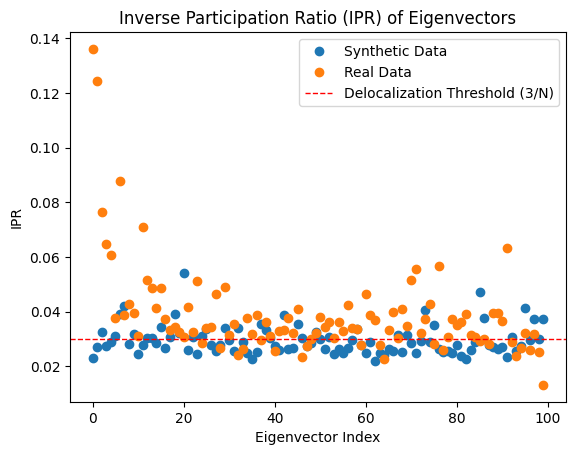

In [29]:
#ipr on real data
from finrmt.spectra import ipr
eigvecs = np.linalg.eigh(C)[1]
ipr_values = ipr(eigvecs)
R_gauss = np.random.normal(0, 1, size=(T, N))
T, N = R.shape
C_gauss = (1/T) * R_gauss.T @ R_gauss
eigvecs_gauss = np.linalg.eigh(C_gauss)[1]
ipr_values_gauss = ipr(eigvecs_gauss)
#mark the outliers
plt.plot(ipr_values_gauss, 'o', label='Synthetic Data')
plt.plot(ipr_values, 'o', label='Real Data')
plt.axhline(3/N, color='r', linestyle='dashed', linewidth=1, label='Delocalization Threshold (3/N)', xmin=0, xmax=105)
plt.title("Inverse Participation Ratio (IPR) of Eigenvectors")
plt.xlabel("Eigenvector Index")
plt.ylabel("IPR")
plt.legend()
plt.show()

In [30]:
import numpy as np
import pandas as pd

# eigvals, eigvecs da np.linalg.eigh(C)
eigvals, eigvecs = np.linalg.eigh(C)

# calcolo IPR
ipr = np.sum(eigvecs**4, axis=0)

# soglia di delocalizzazione
thr = 3/C.shape[0]

outlier_idx = np.where(ipr > thr*2)[0]   # es. due volte la soglia
print("Autovettori localizzati:", outlier_idx)

for idx in outlier_idx:
    v = eigvecs[:, idx]
    top_assets = np.argsort(-np.abs(v))[:10]   # primi 10 titoli per modulo coefficiente
    print(f"Eigenvalue {eigvals[idx]:.2f}, IPR {ipr[idx]:.3f}")
    print("Top assets:", ret.columns[top_assets].to_list())


Autovettori localizzati: [ 0  1  2  3  4  6 11 91]
Eigenvalue 0.11, IPR 0.136
Top assets: ['CMS', 'BXP', 'AEE', 'CFG', 'BAC', 'ARE', 'C', 'AMP', 'AWK', 'ALLE']
Eigenvalue 0.11, IPR 0.124
Top assets: ['BXP', 'BAC', 'ARE', 'C', 'CFG', 'AMAT', 'ACGL', 'CNP', 'AMP', 'APH']
Eigenvalue 0.12, IPR 0.077
Top assets: ['AMT', 'CCI', 'AEP', 'AEE', 'BAC', 'CMS', 'AMAT', 'ANET', 'AWK', 'APH']
Eigenvalue 0.13, IPR 0.065
Top assets: ['CMS', 'CCI', 'AMT', 'AEP', 'BAC', 'ARE', 'AIG', 'C', 'ATO', 'CB']
Eigenvalue 0.13, IPR 0.061
Top assets: ['CCI', 'AMT', 'AMAT', 'ATO', 'AIG', 'AFL', 'CDNS', 'CMS', 'CFG', 'AME']
Eigenvalue 0.16, IPR 0.088
Top assets: ['AEE', 'AMP', 'AVB', 'ATO', 'ARE', 'ADI', 'ACGL', 'AEP', 'BAC', 'CB']
Eigenvalue 0.19, IPR 0.071
Top assets: ['AJG', 'AON', 'BRO', 'AVY', 'AMCR', 'BKR', 'APA', 'APH', 'BX', 'BLK']
Eigenvalue 1.59, IPR 0.063
Top assets: ['CHRW', 'APTV', 'AME', 'ACGL', 'APD', 'AFL', 'BA', 'CAT', 'BIIB', 'BALL']
